In [1]:
import sys
print("Python Interpreter: ",sys.executable)

import qiskit 
print("Qiskit version: ",qiskit.__version__)

Python Interpreter:  c:\Users\kchar\OneDrive\Desktop\Uni\Hiwi_Orth\Qiskit\qiskit-venv\Scripts\python.exe
Qiskit version:  2.0.2


In [2]:
import numpy as np
from scipy.linalg import expm
from scipy.optimize import minimize
from scipy.linalg import eigh

from qiskit_ibm_runtime.fake_provider import FakeAthensV2
from qiskit.visualization import plot_gate_map

backend = FakeAthensV2()

plot_gate_map(backend)


def kron_N(operator_list):
    result = operator_list[0]
    for op in operator_list[1:]:
        result = np.kron(result, op)
    return result

# Einzelne Pauli-Matrizen
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

# Hamiltonian bauen

def build_topological_hamiltonian(hx, hz, backend, J=-1):
    N = backend.configuration().num_qubits
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    I = np.eye(2)

    def kron_N(ops):
        res = ops[0]
        for op in ops[1:]:
            res = np.kron(res, op)
        return res

    H = np.zeros((2**N, 2**N), dtype=complex)

    # ZZ-Terme entsprechend der Coupling Map
    for i, j in backend.configuration().coupling_map:
        ops = [I]*N
        ops[i] = Z
        ops[j] = Z
        H += J * kron_N(ops)

    # Ein-Qubit-Felder
    for i in range(N):
        ops_x = [I]*N
        ops_z = [I]*N
        ops_x[i] = X
        ops_z[i] = Z
        H += hx * kron_N(ops_x) + hz * kron_N(ops_z)

    return H

def build_hamiltonian(hx, hz, N, J=-1):
    H = np.zeros((2**N, 2**N), dtype=complex)
    
    # ZZ-Kopplung
    for i in range(N - 1):
        ops = [I]*N
        ops[i] = Z
        ops[i+1] = Z
        H += J * kron_N(ops)
    
    # Feldterme
    for i in range(N):
        ops_X = [I]*N
        ops_Z = [I]*N
        ops_X[i] = X
        ops_Z[i] = Z
        H += hx * kron_N(ops_X) + hz * kron_N(ops_Z)
    
    return H

# Unitary-Funktion effizient definiert
def U_x(gamma, N):
    U = np.eye(2**N, dtype=complex)
    for i in range(N):
        ops = [I]*N
        ops[i] = X
        U = U @ expm(-1j * gamma / 2 * kron_N(ops))
    return U

def U_z(beta, N):
    U = np.eye(2**N, dtype=complex)
    for i in range(N):
        ops = [I]*N
        ops[i] = Z
        U = U @ expm(-1j * beta / 2 * kron_N(ops))
    return U

def U_zz(alpha, N):
    U = np.eye(2**N, dtype=complex)
    for i in range(N - 1):
        ops = [I]*N
        ops[i] = Z
        ops[i+1] = Z
        U = U @ expm(-1j * alpha / 2 * kron_N(ops))
    return U

# Variationsenergie berechnen
def variational_energy(params, H, N):
    alpha, beta, gamma = params
    state = np.ones(2**N)/np.sqrt(2**N)  # Anfangszustand |+>^N
    state = U_zz(alpha, N) @ state
    state = U_z(beta, N) @ state
    state = U_x(gamma, N) @ state
    energy = state.conj().T @ H @ state
    return np.real(energy)

def variational_error(params, H, N, E_exact):
    return abs(variational_energy(params, H, N) - E_exact)

# Optimierung durchführen
hx, hz = 1.0, 0.5
N = 4
H = build_hamiltonian(hx, hz, N)

eigvals_exact, eigvecs_exact = eigh(H)
ground_energy_exact = np.min(eigvals_exact)

def find_best_params(H,N, ground_energy_exact):
    best_params = None
    min_error = np.inf

    alpha_vals = np.linspace(-np.pi, np.pi, 5)
    beta_vals =  np.linspace(-np.pi, np.pi, 5)
    gamma_vals = np.linspace(-np.pi, np.pi, 5)

    for alpha in alpha_vals:
        for beta in beta_vals:
            for gamma in gamma_vals:
                params = [alpha, beta, gamma]
                error = variational_error(params, H, N, ground_energy_exact)
                if error < min_error:
                    min_error = error
                    best_params = params
    return best_params, min_error

best_params, min_error = find_best_params(H,N,ground_energy_exact)

optimal_energy = variational_energy(best_params, H, N)
print("Optimierte Parameter (alpha, beta, gamma):", best_params)
print("Optimale Variationsenergie:", optimal_energy)
print("Exakte Grundzustandsenergie:", ground_energy_exact)
print("Minimaler Energiefehler:", min_error)

Optimierte Parameter (alpha, beta, gamma): [np.float64(0.0), np.float64(-1.5707963267948966), np.float64(1.5707963267948966)]
Optimale Variationsenergie: -5.000000000000002
Exakte Grundzustandsenergie: -6.054765816905964
Minimaler Energiefehler: 1.0547658169059622


In [3]:
# Numerischer Gradient
def compute_gradient(params, H, N, delta=1e-5):
    grad = np.zeros_like(params)
    base = variational_energy(params, H, N)
    for i in range(len(params)):
        shift = np.zeros_like(params)
        shift[i] = delta
        grad[i] = (variational_energy(params + shift, H, N) - base) / delta
    return grad

# Gradient Descent
def gradient_descent(H, N, E_exact, params, lr=0.1, steps=100):
    energy_log = []

    for step in range(steps):
        energy = variational_energy(params, H, N)
        grad = compute_gradient(params, H, N)
        params -= lr * grad

        error = abs(energy - E_exact)
        energy_log.append((energy, error))
        
        """
        if step % 50 == 0:
            print(f"Step {step}: Energy = {energy:.6f}, Error = {error:.6f}")
        """

    return params, energy_log[-1], energy_log


H = build_hamiltonian(hx, hz, N)
eigvals_exact, _ = eigh(H)
ground_energy_exact = np.min(eigvals_exact)
best_params, _ = find_best_params(H,N, ground_energy_exact)
params_opt, (E_opt, error), log = gradient_descent(H, N, ground_energy_exact, best_params)

print("\n--- Ergebnis ---")
print("Optimierte Parameter (alpha, beta, gamma):", params_opt)
print("Optimierte Energie:", E_opt)
print("Exakte Energie:", ground_energy_exact)
print("Fehler:", error)



--- Ergebnis ---
Optimierte Parameter (alpha, beta, gamma): [-7.90123522e-06 -2.07472406e+00  1.57078772e+00]
Optimierte Energie: -5.983373785243895
Exakte Energie: -6.054765816905964
Fehler: 0.07139203166206887


Full Grid: 100%|██████████| 400/400 [11:05<00:00,  1.66s/it]


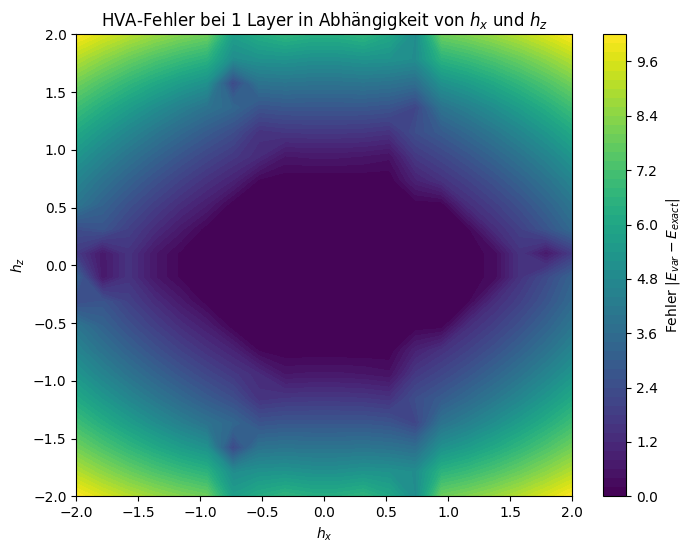

In [4]:
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm


hx_vals = np.linspace(-2, 2.0, 20)
hz_vals = np.linspace(-2, 2.0, 20)
error_grid = np.zeros((len(hx_vals), len(hz_vals)))
param_grid = np.zeros((len(hx_vals), len(hz_vals), 3))
N = backend.configuration().num_qubits

for (i, hx), (j, hz) in tqdm(product(enumerate(hx_vals), enumerate(hz_vals)),
                             total=len(hx_vals)*len(hz_vals), desc="Full Grid"):
        H = build_topological_hamiltonian(hx, hz, backend)
        eigvals_exact, _ = eigh(H)
        ground_energy_exact = np.min(eigvals_exact)
        best_params, _ = find_best_params(H,N, ground_energy_exact)
        params_opt, (E_opt, error), log = gradient_descent(H, N, ground_energy_exact, best_params)

        error_grid[i, j] = error
        param_grid[i, j, :] = params_opt  # speichert alpha, beta, gamma

# Plot
hx_mesh, hz_mesh = np.meshgrid(hz_vals, hx_vals)
plt.figure(figsize=(8,6))
cp = plt.contourf(hz_mesh, hx_mesh, error_grid, levels=50, cmap='viridis')
plt.colorbar(cp, label='Fehler $|E_{var} - E_{exact}|$')
plt.xlabel('$h_x$')
plt.ylabel('$h_z$')
plt.title('HVA-Fehler bei 1 Layer in Abhängigkeit von $h_x$ und $h_z$')
plt.show()

    

In [5]:
# Maximalen Fehlerwert berechnen
max_error = np.max(error_grid)

# Index (Zeile, Spalte) des Maximalwerts finden
max_index = np.unravel_index(np.argmax(error_grid), error_grid.shape)

print("Maximaler Fehlerwert:", max_error)
print("Index im Grid (row, col):", max_index)

# Optional: die zugehörigen h_x und h_z Werte
hx_max = hx_vals[max_index[0]]
hz_max = hz_vals[max_index[1]]

print("Zugehörige Werte: h_x =", hx_max, ", h_z =", hz_max)

Maximaler Fehlerwert: 10.19621771660787
Index im Grid (row, col): (np.int64(0), np.int64(19))
Zugehörige Werte: h_x = -2.0 , h_z = 2.0


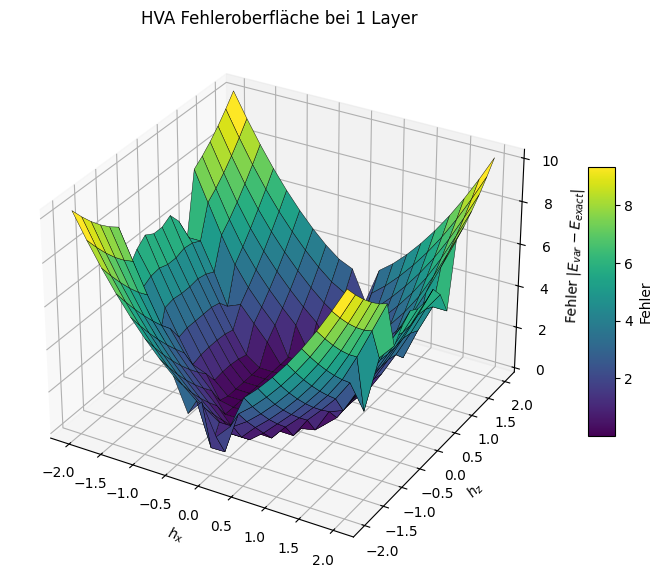

In [6]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(hx_mesh, hz_mesh, error_grid,
                       cmap='viridis', edgecolor='k', linewidth=0.3, antialiased=True)

ax.set_xlabel('$h_x$')
ax.set_ylabel('$h_z$')
ax.set_zlabel('Fehler $|E_{var} - E_{exact}|$')
ax.set_title('HVA Fehleroberfläche bei 1 Layer')
fig.colorbar(surf, shrink=0.5, aspect=10, label='Fehler')

plt.show()
